# Analysis DA-Approach - UMG (Patient data)

/tmp/ipykernel_63394/3163097272.py:73: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=plot_df, x='Model', y='Predicted_AUC', hue='Response_Group',


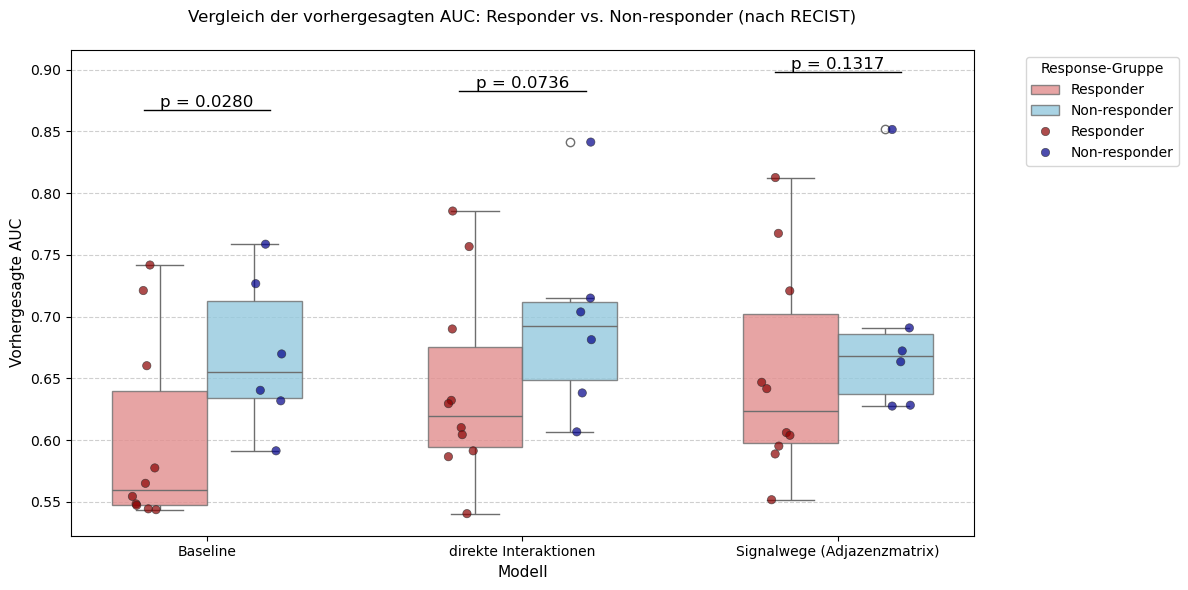

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# PDX-Dataset mit RECIST oder AUC laden (Index passt)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)

# Dictionary für die Modelle
models = {
    'Baseline': './results/DA/UMG/preds_AUC_bce_loss_new_parameter_Goe.csv',
    'direkte Interaktionen': './results/DA/UMG/preds_AUC_direct_bce_loss_new_parameter_Goe.csv',
    'Signalwege (Adjazenzmatrix)': './results/DA/UMG/preds_AUC_pathway_weight_bce_loss_new_parameter_Goe.csv'
}


plot_data = []
for model_name, file_path in models.items():
    preds = pd.read_csv(file_path, index_col=0)

    # Retrieve responder status from pdx_dataset
    preds['Responder_Status'] = pdx_dataset['Gemcitabine']
    preds.dropna(subset=['Responder_Status'], inplace=True)
    preds['Responder_Status'] = preds['Responder_Status'].astype(int)
    preds['Response_Group'] = preds['Responder_Status'].map({1: 'Responder', 0: 'Non-responder'})

    for idx, row in preds.iterrows():
        plot_data.append({
            'Model': model_name,
            'Response_Group': row['Response_Group'],
            'Predicted_AUC': row['Gemcitabine']
        })


plot_df = pd.DataFrame(plot_data)

# Function: Mann-Whitney U test per model + p-value + annotation
def add_pvalue_annotation(ax, df, models_list, y_offset=0.05):
    y_max = df['Predicted_AUC'].max()
    y_range = df['Predicted_AUC'].max() - df['Predicted_AUC'].min()
    y_start = y_max + y_range * 0.05  # Starthöhe über den Boxplots
    height_step = y_range * y_offset

    for i, model_name in enumerate(models_list):
        data = df[df['Model'] == model_name]
        responder = data[data['Response_Group'] == 'Responder']['Predicted_AUC']
        non_responder = data[data['Response_Group'] == 'Non-responder']['Predicted_AUC']

        if len(responder) == 0 or len(non_responder) == 0:
            continue

        # One-sided test: expect responders to have lower AUC
        stat, p_val = mannwhitneyu(responder, non_responder, alternative='less')
        y_pos = y_start + i * height_step
        ax.plot([i - 0.2, i + 0.2], [y_pos, y_pos], color='black', linewidth=1)
        ax.text(i, y_pos, f'p = {p_val:.4f}', ha='center', va='bottom', fontsize=12)

# Create Plot
plt.figure(figsize=(12, 6))

ax = sns.boxplot(data=plot_df, x='Model', y='Predicted_AUC',
                 hue='Response_Group',
                 palette={'Responder': 'lightcoral', 'Non-responder': 'skyblue'},
                 boxprops=dict(alpha=0.8), width=0.6)

sns.stripplot(data=plot_df, x='Model', y='Predicted_AUC', hue='Response_Group',
              palette={'Responder': 'darkred', 'Non-responder': 'darkblue'},
              dodge=True, jitter=True, alpha=0.7, size=6, edgecolor='gray', linewidth=0.5)


plt.title('Vergleich der vorhergesagten AUC: Responder vs. Non-responder (nach RECIST)', fontsize=12, pad=20)
plt.ylabel('Vorhergesagte AUC', fontsize=11)
plt.xlabel('Modell', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
add_pvalue_annotation(ax, plot_df, models_list=list(models.keys()), y_offset=0.05)
plt.legend(title='Response-Gruppe', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()